In [238]:
import numpy as np
import matplotlib.pyplot as plt
import cma

# Defining Model Curves

### Pruning vs Accuracy

In [239]:
def get_accuracy(p):
    #6th order polynomial coefficients
    coeffs = [83.90, 52.05, -1521, 7846, -17546, 17922, -6857]
    
    acc = sum(c * p**i for i, c in enumerate(coeffs))

    return max(acc, 0)

### Pruning vs Model Size

In [240]:
def get_size(p):
    b1 = -419.2
    b0 = 440.0
    
    return b0 + b1 * p

### Pruning vs Inference Time

In [241]:
def get_time(p):
    b0 = 0.9855
    b1 = -0.9494
    b2 = 1.526
    b3 = -1.557
    
    return b0 + b1 * p + b2 * p**2 + b3 * p**3

In [242]:
def normalize(arr):
    min_element = min(arr)
    max_element = max(arr)
    return [(x - min_element) / (max_element - min_element) for x in arr]

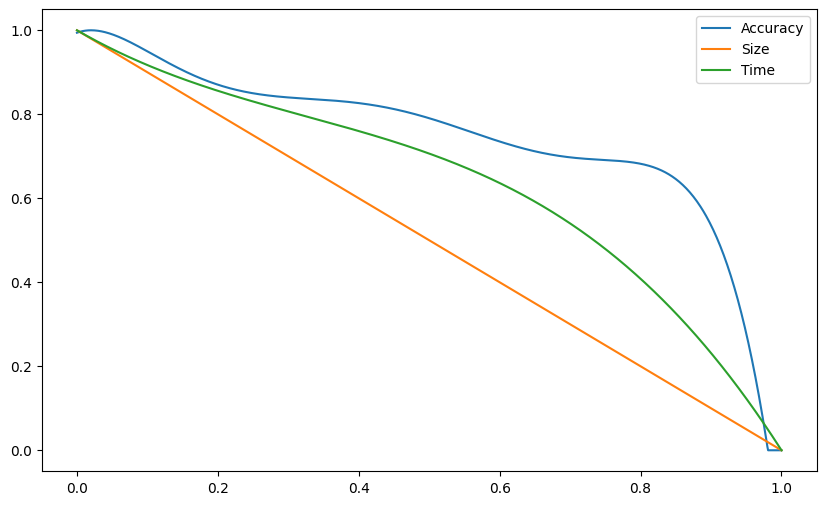

In [243]:
pruning_amounts = np.arange(0.0, 1.001, 0.001)
plt.figure(figsize=(10, 6))
accuracies = [get_accuracy(p) for p in pruning_amounts]
sizes = [get_size(p) for p in pruning_amounts]
times = [get_time(p) for p in pruning_amounts]

plt.plot(pruning_amounts, normalize(accuracies), label='Accuracy')
plt.plot(pruning_amounts, normalize(sizes), label='Size')
plt.plot(pruning_amounts, normalize(times), label='Time')
plt.legend()

# Defining Rewards

### Accuracy Reward

In [244]:
def get_accuracy_reward(curr_accuracy, min_accuracy, sigma_right=4, sigma_left=2):
    diff = curr_accuracy - min_accuracy
    if 0<=diff<=1e-2:
        return (np.exp(- (diff**2) / (10 * sigma_left**2)) * 100)
    else:
        return 1*(np.exp(- (abs(diff)**1.5) / (2 * sigma_right**2)) * 100)

In [245]:
min_accuracy = float(input("Enter the minimum acceptable accuracy: ") or 80.0)
acc_rewards = []
accuracies = []
pruning_amounts = np.arange(0.0, 1.001, 0.001)
for p in pruning_amounts:
    accuracy = get_accuracy(p)
    reward = get_accuracy_reward(accuracy, min_accuracy=80)
    accuracies.append(accuracy)
    acc_rewards.append(reward)

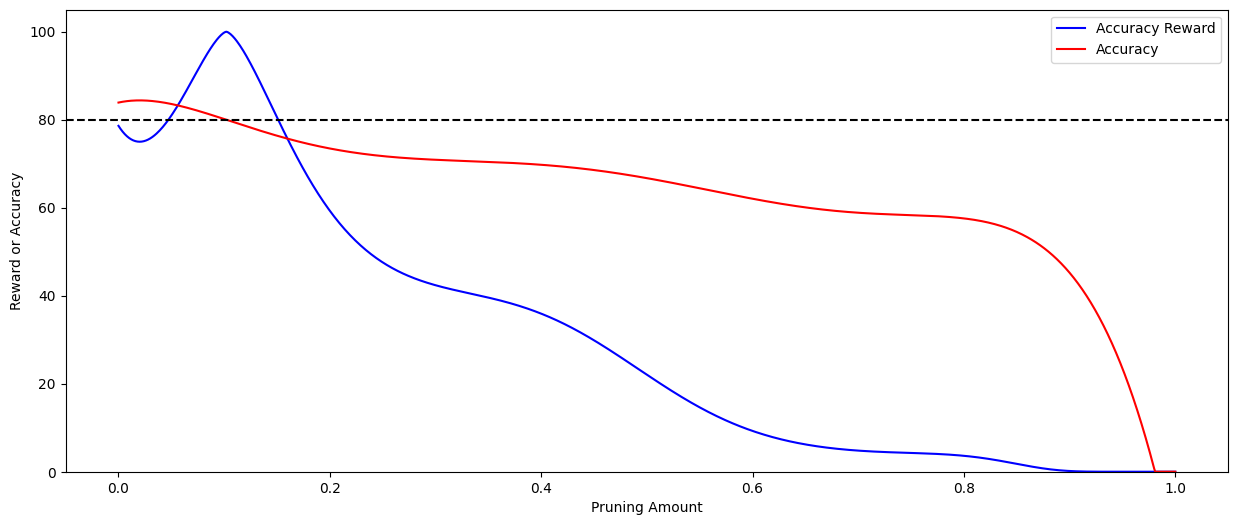

In [246]:
plt.style.use('default')
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(pruning_amounts, acc_rewards, label='Accuracy Reward', color='blue')
plt.plot(pruning_amounts, accuracies, label='Accuracy', color='red')
plt.ylim(0)
plt.axhline(y=80, color='black', linestyle='--')
plt.xlabel('Pruning Amount')
plt.ylabel('Reward or Accuracy')
plt.legend()

### Inference Time Reward

In [247]:
def get_comp_time_reward(current_comp_time, sigma=0.8):
    return np.exp(- (current_comp_time**2) / (2 * sigma**2))*50

In [248]:
time_rewards = []
comp_times = []
for p in pruning_amounts:
    time = get_time(p)
    reward = get_comp_time_reward(time)
    comp_times.append(time)
    time_rewards.append(reward)

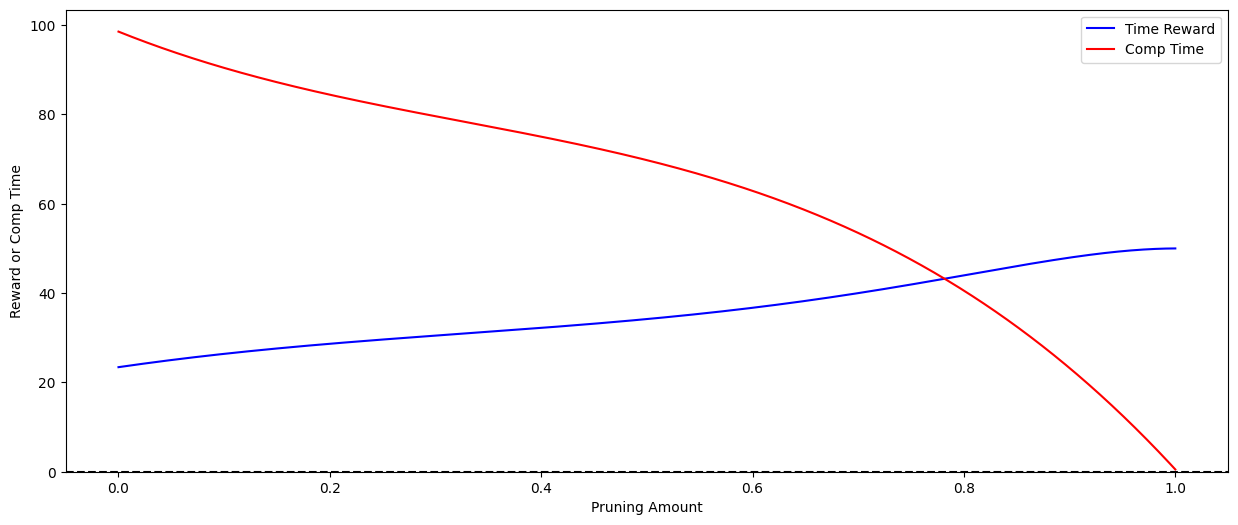

In [249]:
plt.style.use('default')
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(pruning_amounts, time_rewards, label='Time Reward', color='blue')
plt.plot(pruning_amounts, [x * 100 for x in comp_times], label='Comp Time', color='red')
plt.ylim(0)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Pruning Amount')
plt.ylabel('Reward or Comp Time')
plt.legend()

### Model Size Reward

In [381]:
def get_model_size_reward(current_model_size, max_model_size, sigma_left=2):
    diff = current_model_size - max_model_size
    if current_model_size > max_model_size:
        return np.exp(- ((diff)**2) / (10 * sigma_left**2))*99
    if current_model_size == max_model_size:
        return 99
    else:
        return (99+(current_model_size/max_model_size))

In [382]:
size_rewards = []
sizes = []
# max_model_size = float(input("Enter the maximum acceptable model size: ") or 300.0)
for p in pruning_amounts:
    size = get_size(p)
    reward = get_model_size_reward(size, max_model_size=300)
    sizes.append(size)
    size_rewards.append(reward)

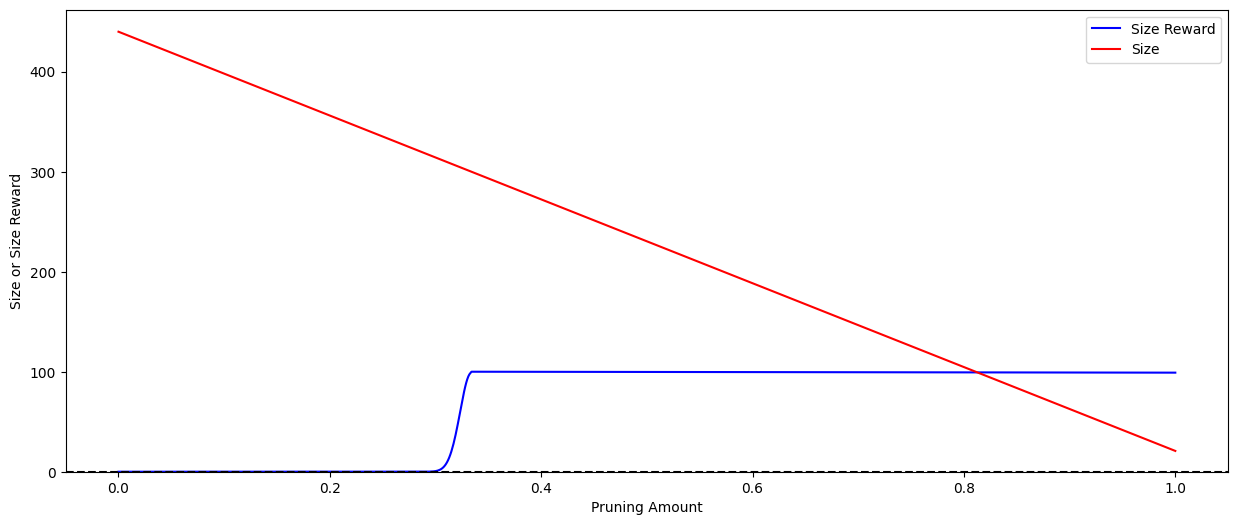

In [383]:
plt.style.use('default')
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(pruning_amounts, size_rewards, label='Size Reward', color='blue')
plt.plot(pruning_amounts, sizes, label='Size', color='red')
plt.ylim(0)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Pruning Amount')
plt.ylabel('Size or Size Reward')
plt.legend()

### Reward for better pruning

In [341]:
def more_acc_less_size(accuracy, min_accuracy, size, max_model_size):
    if accuracy >= min_accuracy and size <= max_model_size:
        return ((accuracy-min_accuracy)*2) + (max_model_size-size)/2
    return 0

In [342]:
counts_of_calulating_rewards = 0

### Final Reward Calculation

In [365]:
def get_reward(p, min_accuracy=80.0, max_model_size=300.0, x=1, y=1, z=1) -> float:
    accuracy = get_accuracy(p)
    time = get_time(p)
    size = get_size(p)
    
    acc_reward = np.array(get_accuracy_reward(accuracy, min_accuracy))
    time_reward = np.array(get_comp_time_reward(time))
    size_reward = np.array(get_model_size_reward(size, max_model_size))
    better_reward = more_acc_less_size(accuracy, min_accuracy, size, max_model_size)
    global counts_of_calulating_rewards
    counts_of_calulating_rewards += 1 # type: ignore
    
    x, y, z = x/(x+y+z), y/(x+y+z), z/(x+y+z)
    
    return (x*acc_reward + y*time_reward + z*size_reward + better_reward + p/2)

In [366]:
def get_details(p,min_accuracy, max_model_size):
    return {
        'Min Accuracy Required': min_accuracy,
        'Max Model Size Required': max_model_size,
        'Pruning Amount': p,
        "Accuracy": get_accuracy(p),
        "Time": get_time(p),
        "Size": get_size(p),
        "Accuracy Reward": get_accuracy_reward(get_accuracy(p), min_accuracy),
        "Time Reward": get_comp_time_reward(get_time(p)),
        "Size Reward": get_model_size_reward(get_size(p), max_model_size),
        "More Acc Less Size Reward": more_acc_less_size(get_accuracy(p), min_accuracy, get_size(p), max_model_size),
        "Pruning Reward": p * 100,
        "Total Reward": get_reward(p),
    }

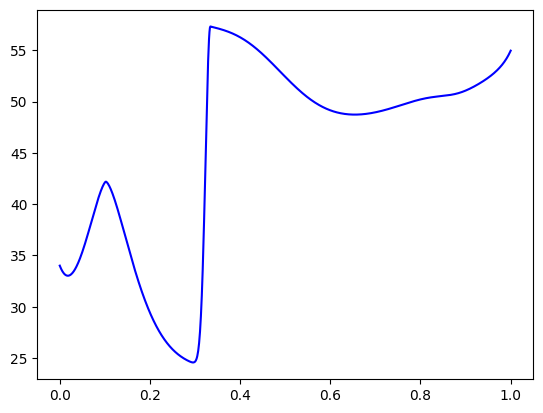

In [367]:
pruning_amounts = np.arange(0.0, 1.001, 0.001)
min_accuracy = 80.0
max_model_size = 300.0
results = [get_details(p, min_accuracy, max_model_size) for p in pruning_amounts]

plt.plot(pruning_amounts, [r['Total Reward'] for r in results], label='Total Reward', color='blue')

# Global Optimization with CMA-ES
Here we apply the CMA-ES evolutionary strategy for robust, gradient-free maximization of the total reward over the pruning amount.

In [368]:
def get_best_pruning_amount(min_accuracy=80.0, max_model_size=300.0, normalized_importance=None):
    def objective(x):
        p = x[0]
        return -1 * get_reward(p, min_accuracy=min_accuracy, max_model_size=max_model_size) 

    x0 = [0.1, 0.0]
    sigma = 0.2
    bounds = [[0.0, -float('inf')], [1.0, float('inf')]]

    es = cma.CMAEvolutionStrategy(x0, sigma, {
        'bounds': bounds,
        'popsize': 20,
        'CMA_diagonal': 0
    })

    for _ in range(100):
        candidates = es.ask()
        fitnesses = [objective(c) for c in candidates]
        es.tell(candidates, fitnesses)

    opt_p = es.result.xbest[0]
    # print(f"CMA-ES found optimal pruning amount: {opt_p:.4f}")
    # print(f"Maximum reward: {-es.result.fbest:.4f}")
    # print(f"Number of reward calculations: {counts_of_calulating_rewards}") # type: ignore
    return opt_p.item()

In [369]:
rewards = [get_reward(p) for p in pruning_amounts]
max_index = np.argmax(rewards)
max_reward = rewards[max_index]

In [370]:
min_accuracy = float(input("Enter the minimum acceptable accuracy: ") or 80.0)
max_model_size = float(input("Enter the maximum acceptable model size: ") or 300.0)

In [371]:
opt_p = get_best_pruning_amount(min_accuracy=min_accuracy, max_model_size=max_model_size)

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 2 (seed=695401, Fri Jul  4 10:04:01 2025)
NOTE (module=cma, iteration=33):  
condition in coordinate system exceeded 1.3e+08, rescaled to 1.0e+00, 
condition changed from 3.1e+07 to 1.2e+00
NOTE (module=cma, iteration=60):  
condition in coordinate system exceeded 1.5e+08, rescaled to 1.0e+00, 
condition changed from 1.5e+08 to 4.0e+00


In [372]:
print(opt_p)

0.33393070775592154


In [373]:
get_details(opt_p, min_accuracy=min_accuracy, max_model_size=max_model_size)

{'Min Accuracy Required': 80.0,
 'Max Model Size Required': 300.0,
 'Pruning Amount': 0.33393070775592154,
 'Accuracy': 70.56695955858734,
 'Time': 0.7806527551382152,
 'Size': 300.01624730871765,
 'Accuracy Reward': np.float64(40.43909960423463),
 'Time Reward': np.float64(31.05980772368573),
 'Size Reward': np.float64(99.99934006457617),
 'More Acc Less Size Reward': 0,
 'Pruning Reward': 33.39307077559216,
 'Total Reward': np.float64(57.333047818043475)}

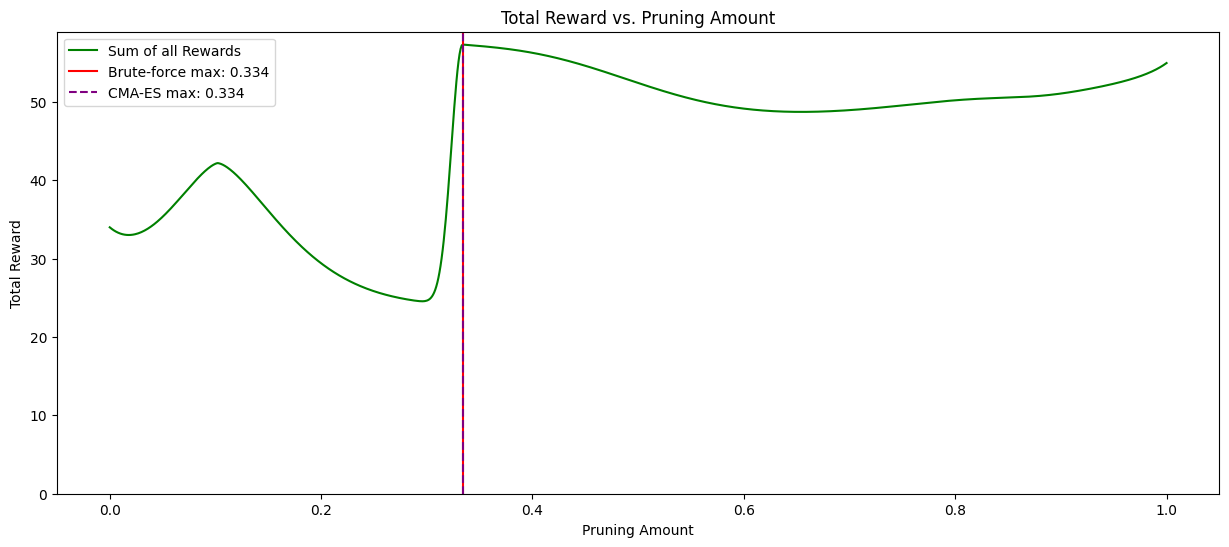

Brute-force search optimal pruning amount: 0.3340
CMA-ES found optimal pruning amount: 0.3339
Reward at brute-force optimum: 57.33
Reward at CMA-ES optimum: 57.33


In [374]:
# Plotting the results to compare brute-force and CMA-ES
plt.style.use('default')
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(pruning_amounts, rewards, label='Sum of all Rewards', color='green')

# Brute-force result
brute_force_p = pruning_amounts[max_index]
plt.axvline(x=brute_force_p, color='red', linestyle='-', label=f'Brute-force max: {brute_force_p:.3f}')

# CMA-ES result
plt.axvline(x=opt_p, color='purple', linestyle='--', label=f'CMA-ES max: {opt_p:.3f}')

plt.ylim(0)
plt.xlabel('Pruning Amount')
plt.ylabel('Total Reward')
plt.title('Total Reward vs. Pruning Amount')
plt.legend()
plt.show()

print(f"Brute-force search optimal pruning amount: {brute_force_p:.4f}")
print(f"CMA-ES found optimal pruning amount: {opt_p:.4f}")

# Also print the rewards at these points
reward_brute_force = get_reward(brute_force_p)
reward_cma_es = get_reward(opt_p)

print(f"Reward at brute-force optimum: {reward_brute_force:.2f}")
print(f"Reward at CMA-ES optimum: {reward_cma_es:.2f}")

In [364]:
get_details(brute_force_p, min_accuracy=min_accuracy, max_model_size=max_model_size)

{'Min Accuracy Required': 80.0,
 'Max Model Size Required': 300.0,
 'Pruning Amount': np.float64(0.334),
 'Accuracy': np.float64(70.56633296265761),
 'Time': np.float64(0.7806214968720001),
 'Size': np.float64(299.98720000000003),
 'Accuracy Reward': np.float64(40.43545169689317),
 'Time Reward': np.float64(31.0609919675836),
 'Size Reward': np.float64(100.00004266848718),
 'More Acc Less Size Reward': 0,
 'Pruning Reward': np.float64(33.4),
 'Total Reward': np.float64(57.49949544432132)}

# Importance of Each View

In [266]:
ranking = {
    0:0.8311827956989247,
    1:0.8623655913978494,
    2:0.8559139784946237,
    3:0.8521505376344086,
    4:0.853225806451613,
    5:0.8510752688172043,
    6:0.8516129032258064,
    7:0.8290322580645161,
    8:0.7919354838709678,
    9:0.8333333333333334,
    10:0.864516129032258,
    11:0.8521505376344086,
    }

In [267]:
total = sum(ranking.values())
ranking = {k: v / total for k, v in ranking.items()}
ranking

{0: 0.08206380381124263,
 1: 0.08514252348850787,
 2: 0.08450554700355645,
 3: 0.08413397738733479,
 4: 0.0842401401348267,
 5: 0.08402781463984288,
 6: 0.08408089601358883,
 7: 0.08185147831625882,
 8: 0.0781888635277881,
 9: 0.08227612930622645,
 10: 0.08535484898349169,
 11: 0.08413397738733479}

In [268]:
ranking_unsorted = {
    view: drop
    for view, drop in sorted(
        ranking.items(),
        key=lambda item: item[0],
        reverse=False
    )
}

In [269]:
ranking_unsorted

{0: 0.08206380381124263,
 1: 0.08514252348850787,
 2: 0.08450554700355645,
 3: 0.08413397738733479,
 4: 0.0842401401348267,
 5: 0.08402781463984288,
 6: 0.08408089601358883,
 7: 0.08185147831625882,
 8: 0.0781888635277881,
 9: 0.08227612930622645,
 10: 0.08535484898349169,
 11: 0.08413397738733479}

In [270]:
max_imp = max(ranking.values())
min_imp = min(ranking.values())

In [271]:
normalized_importance = {
    v: (ranking[v] - min_imp) / (max_imp - min_imp) for v in ranking
}

In [272]:
normalized_importance

{0: 0.5407407407407406,
 1: 0.9703703703703693,
 2: 0.8814814814814813,
 3: 0.8296296296296306,
 4: 0.844444444444446,
 5: 0.8148148148148153,
 6: 0.822222222222222,
 7: 0.5111111111111101,
 8: 0.0,
 9: 0.5703703703703713,
 10: 1.0,
 11: 0.8296296296296306}

# Importance-Inverse Pruning Strategy

This implementation ensures a strict inverse relationship between view importance and pruning amount:
- Higher importance views → Lower pruning (preserve important views)
- Lower importance views → Higher pruning (aggressively prune less important views)

The approach directly incorporates this relationship into the CMA-ES objective function.

In [273]:
def get_importance_inverse_pruning(normalized_importance, global_accuracy=85.0, max_model_size=300.0):
    """
    Calculate pruning amounts that are strictly inversely proportional to view importance.
    Uses CMA-ES to optimize pruning for each view while preserving the inverse relationship.
    HIGHER IMPORTANCE = LESS PRUNING
    LOWER IMPORTANCE = MORE PRUNING
    """
    import numpy as np
    import cma
    
    # Function to compute weighted accuracy
    def compute_weighted_accuracy(pruning_amounts):
        per_view_acc = {v: get_accuracy(pruning_amounts[v]) for v in normalized_importance}
        weight_sum = sum(normalized_importance.values())
        normalized_weights = {k: v/weight_sum for k, v in normalized_importance.items()}
        weighted_acc = sum(normalized_weights[v] * per_view_acc[v] for v in normalized_importance)
        return weighted_acc
    
    # Initialize with inverse proportional pruning as a starting point
    initial_pruning = {
        v: 0.9 * (1 - importance) for v, importance in normalized_importance.items()
    }
    
    # Apply CMA-ES to find optimal pruning for each view
    pruning_per_view = {}
    
    for view, importance in normalized_importance.items():
        # Create objective function incorporating importance
        def objective(x):
            p = np.clip(x[0], 0.0, 1.0)  # Ensure pruning is within bounds
            
            # Base reward from existing reward function
            base_reward = get_reward(p, min_accuracy=global_accuracy, max_model_size=max_model_size)
            
            # Importance penalty: higher importance = higher penalty for pruning
            # This creates pressure to reduce pruning for important views
            importance_penalty = 200 * p * importance
            
            # Final objective: maximize reward while respecting importance
            return -1 * (base_reward - importance_penalty)
        
        # Initial point: use inverse proportional value
        x0 = [initial_pruning[view]]
        sigma = 0.2  # Step size
        
        options = {
            'bounds': [[0.0], [1.0]],  # Pruning must be between 0 and 1
            'popsize': 10,             # Population size for CMA-ES
            'maxiter': 30,             # Maximum iterations
            'verb_disp': 0,            # No verbose display
            'seed': view * 10 + 42     # Different seed for each view
        }
        
        try:
            # Run CMA-ES to find optimal pruning for this view
            res = cma.fmin(objective, x0, sigma, options)
            pruning_per_view[view] = np.clip(res[0][0], 0.0, 1.0)
        except Exception as e:
            print(f"CMA-ES optimization failed for view {view}: {e}")
            # Fall back to initial value if optimization fails
            pruning_per_view[view] = initial_pruning[view]
    
    # Check if total weighted accuracy meets the global target
    weighted_acc = compute_weighted_accuracy(pruning_per_view)
    
    # If target not met, use CMA-ES to find a global scaling factor
    if weighted_acc < global_accuracy:
        print(f"Initial weighted accuracy {weighted_acc:.2f}% is below target {global_accuracy:.2f}%.")
        print("Using CMA-ES to find optimal scaling factor...")
        
        # Global optimization to find a scaling factor for all pruning values
        def global_scaling_objective(x):
            scale = np.clip(x[0], 0.1, 1.0)
            scaled_pruning = {v: pruning_per_view[v] * scale for v in pruning_per_view}
            
            current_acc = compute_weighted_accuracy(scaled_pruning)
            
            # High penalty for going below target accuracy
            accuracy_penalty = 1000 * max(0, global_accuracy - current_acc)
            
            # Objective: minimize scaling reduction while ensuring accuracy
            return scale + accuracy_penalty
            
        # Initial point and step size for scaling optimization
        x0_scale = [0.8]  # Start with slight reduction in pruning
        sigma_scale = 0.2
        
        options_scale = {
            'bounds': [[0.1], [1.0]],  # Scaling between 10% and 100%
            'popsize': 15,
            'maxiter': 50,
            'verb_disp': 0
        }
        
        try:
            res_scale = cma.fmin(global_scaling_objective, x0_scale, sigma_scale, options_scale)
            best_scale = np.clip(res_scale[0][0], 0.1, 1.0)
            
            # Apply the optimal scaling
            pruning_per_view = {v: p * best_scale for v, p in pruning_per_view.items()}
            print(f"Found optimal scaling factor: {best_scale:.4f}")
        except Exception as e:
            print(f"Global scaling optimization failed: {e}")
            
        # Check final weighted accuracy after scaling
        final_acc = compute_weighted_accuracy(pruning_per_view)
        
        if final_acc < global_accuracy:
            print(f"Warning: Could not reach target accuracy. Achieved: {final_acc:.2f}%")
            
            # Last resort: use CMA-ES for joint optimization of all views
            print("Attempting joint optimization of all views...")
            
            def joint_objective(x):
                # Convert optimization vector to pruning dict
                all_pruning = {v: np.clip(x[i], 0.0, 1.0) for i, v in enumerate(sorted(normalized_importance.keys()))}
                
                # Calculate weighted accuracy
                acc = compute_weighted_accuracy(all_pruning)
                
                # Severe penalty for missing accuracy target
                acc_penalty = 10000 * max(0, global_accuracy - acc)
                
                # Penalty for violating importance relationship
                importance_values = [normalized_importance[v] for v in sorted(normalized_importance.keys())]
                pruning_values = [all_pruning[v] for v in sorted(normalized_importance.keys())]
                
                correlation = np.corrcoef(importance_values, pruning_values)[0, 1]
                relationship_penalty = 5000 * max(0, correlation + 0.5)  # Penalize if correlation > -0.5
                
                # Sum of pruning values (we want to maximize pruning while respecting constraints)
                pruning_sum = sum(pruning_values)
                
                return acc_penalty + relationship_penalty - pruning_sum
            
            # Initial point based on current pruning values
            x0_joint = [pruning_per_view[v] for v in sorted(normalized_importance.keys())]
            sigma_joint = 0.1
            
            options_joint = {
                'bounds': [[0.0] * len(normalized_importance), [1.0] * len(normalized_importance)],
                'popsize': 30,
                'maxiter': 100,
                'verb_disp': 0
            }
            
            try:
                res_joint = cma.fmin(joint_objective, x0_joint, sigma_joint, options_joint)
                for i, v in enumerate(sorted(normalized_importance.keys())):
                    pruning_per_view[v] = np.clip(res_joint[0][i], 0.0, 1.0)
            except Exception as e:
                print(f"Joint optimization failed: {e}")
    
    # Final calculations
    final_weighted_acc = compute_weighted_accuracy(pruning_per_view)
    
    # Check correlation to verify inverse relationship
    imp_values = np.array(list(normalized_importance.values()))
    prune_values = np.array([pruning_per_view[v] for v in normalized_importance])
    correlation = np.corrcoef(imp_values, prune_values)[0, 1]
    
    # Report results
    print(f"Target accuracy: {global_accuracy:.2f}%")
    print(f"Achieved weighted accuracy: {final_weighted_acc:.2f}%")
    print(f"Correlation between importance and pruning: {correlation:.4f}")
    if correlation < 0:
        print("✓ Negative correlation confirms inverse relationship between importance and pruning")
    else:
        print("⚠ WARNING: Inverse relationship not maintained")
    
    return pruning_per_view

In [274]:
result = get_importance_inverse_pruning(normalized_importance, global_accuracy=min_accuracy, max_model_size=max_model_size)

CMA-ES optimization failed for view 0: not yet initialized (dimension needed)


/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.13/site-packages/cma/utilities/utils.py:347: UserWarning: Initial solution argument x0=[0.41333333].
CAVEAT: Optimization in 1-D is poorly tested. (time=Jul  4 09:59:52 2025)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.13/site-packages/cma/utilities/utils.py:347: UserWarning: Initial solution argument x0=[0.02666667].
CAVEAT: Optimization in 1-D is poorly tested. (time=Jul  4 09:59:52 2025)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.13/site-packages/cma/utilities/utils.py:347: UserWarning: Initial solution argument x0=[0.10666667].
CAVEAT: Optimization in 1-D is poorly tested. (time=Jul  4 09:59:52 2025)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.13/site-packages/cma/utilities/utils.py:347: UserWarni

Target accuracy: 80.00%
Achieved weighted accuracy: 81.32%
Correlation between importance and pruning: -0.9748
✓ Negative correlation confirms inverse relationship between importance and pruning


/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.13/site-packages/cma/utilities/utils.py:347: UserWarning: Initial solution argument x0=[0.44].
CAVEAT: Optimization in 1-D is poorly tested. (time=Jul  4 09:59:52 2025)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.13/site-packages/cma/utilities/utils.py:347: UserWarning: Initial solution argument x0=[0.9].
CAVEAT: Optimization in 1-D is poorly tested. (time=Jul  4 09:59:52 2025)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.13/site-packages/cma/utilities/utils.py:347: UserWarning: Initial solution argument x0=[0.38666667].
CAVEAT: Optimization in 1-D is poorly tested. (time=Jul  4 09:59:52 2025)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.13/site-packages/cma/utilities/utils.py:347: UserWarning: Initial s

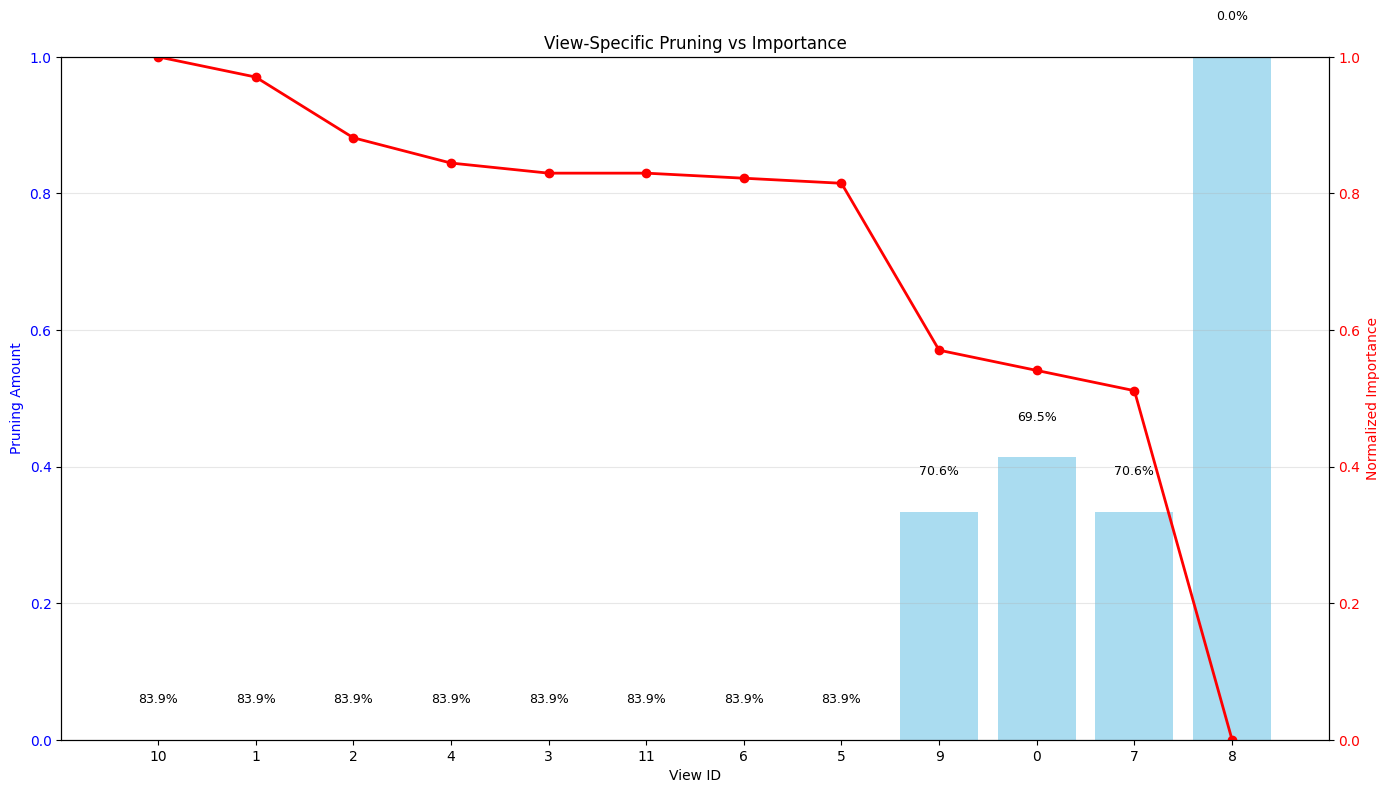

In [275]:
# Visualize the pruning results
import matplotlib.pyplot as plt
import pandas as pd

def plot_pruning_results(pruning_per_view, normalized_importance):
    # Create a DataFrame for easy plotting
    df = pd.DataFrame({
        'View': list(pruning_per_view.keys()),
        'Pruning': list(pruning_per_view.values()),
        'Importance': [normalized_importance[v] for v in pruning_per_view.keys()]
    })
    
    # Sort by importance
    df = df.sort_values('Importance', ascending=False)
    
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Plot bars for pruning amounts
    bars = ax1.bar(df['View'].astype(str), df['Pruning'], color='skyblue', alpha=0.7)
    ax1.set_xlabel('View ID')
    ax1.set_ylabel('Pruning Amount', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_ylim(0, 1.0)
    
    # Plot line for importance
    ax2 = ax1.twinx()
    ax2.plot(range(len(df)), df['Importance'], 'ro-', linewidth=2)
    ax2.set_ylabel('Normalized Importance', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_ylim(0, 1.0)
    
    # Calculate per-view accuracies after pruning
    accuracies = [get_accuracy(p) for p in df['Pruning']]
    
    # Add text labels for accuracies
    for i, (p, acc) in enumerate(zip(df['Pruning'], accuracies)):
        ax1.text(i, p + 0.05, f"{acc:.1f}%", 
                 ha='center', va='bottom', rotation=0, fontsize=9)
    
    plt.title('View-Specific Pruning vs Importance')
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# After calculating the result
plot_pruning_results(result, normalized_importance)

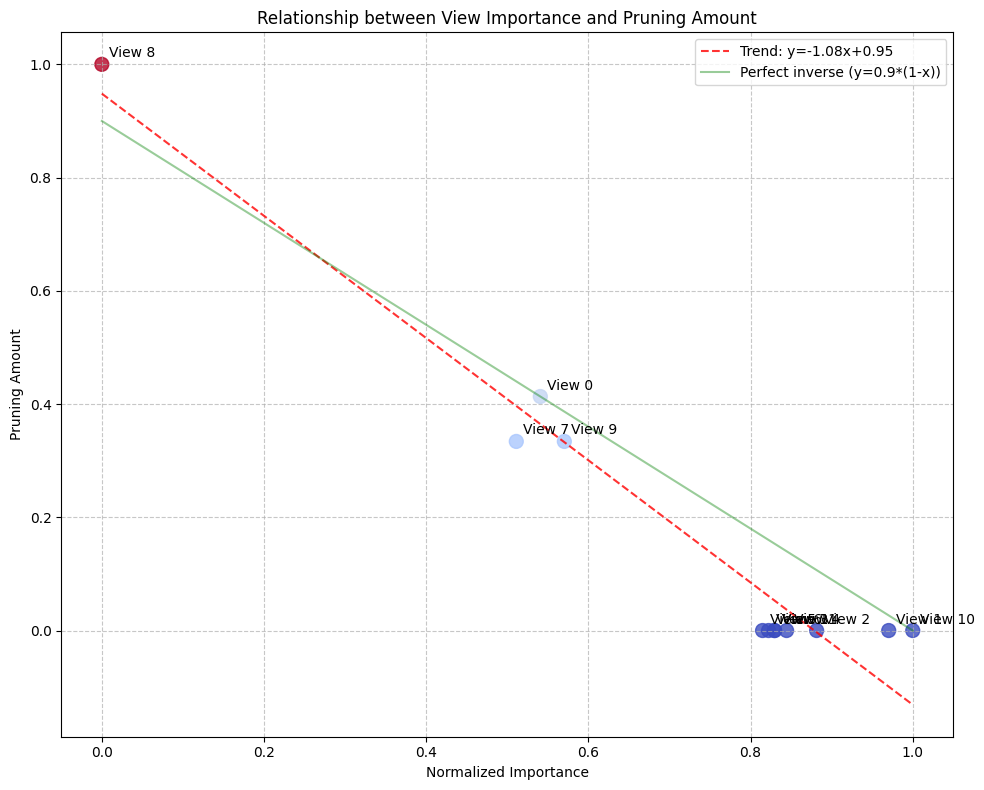

Correlation coefficient: -0.9748
Negative correlation indicates inverse relationship
R²: 0.9503


In [276]:
# Visualize Importance vs. Pruning relationship
def visualize_importance_pruning_relationship(pruning_per_view, normalized_importance):
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Extract values for scatter plot
    importance_values = []
    pruning_values = []
    view_ids = []
    
    for view, importance in normalized_importance.items():
        importance_values.append(importance)
        pruning_values.append(pruning_per_view[view])
        view_ids.append(view)
    
    # Create the scatter plot
    plt.figure(figsize=(10, 8))
    
    # Main scatter plot
    plt.scatter(importance_values, pruning_values, s=100, c=pruning_values, 
                cmap='coolwarm', alpha=0.8)
    
    # Add view ID labels
    for i, view_id in enumerate(view_ids):
        plt.annotate(f"View {view_id}", 
                    (importance_values[i], pruning_values[i]),
                    xytext=(5, 5), textcoords='offset points')
    
    # Add trend line
    z = np.polyfit(importance_values, pruning_values, 1)
    p = np.poly1d(z)
    plt.plot(sorted(importance_values), p(sorted(importance_values)), 
             "r--", alpha=0.8, label=f"Trend: y={z[0]:.2f}x+{z[1]:.2f}")
    
    # Add labels and title
    plt.xlabel('Normalized Importance')
    plt.ylabel('Pruning Amount')
    plt.title('Relationship between View Importance and Pruning Amount')
    
    # Add horizontal and vertical grid lines
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add perfect inverse relationship reference line
    x_ref = np.linspace(0, 1, 100)
    y_ref = 0.9 * (1 - x_ref)  # The ideal inverse relationship
    plt.plot(x_ref, y_ref, 'g-', alpha=0.4, label="Perfect inverse (y=0.9*(1-x))")
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Calculate and print correlation
    correlation = np.corrcoef(importance_values, pruning_values)[0, 1]
    print(f"Correlation coefficient: {correlation:.4f}")
    print("Negative correlation indicates inverse relationship")
    print(f"R²: {correlation**2:.4f}")

# Visualize the importance-pruning relationship
visualize_importance_pruning_relationship(result, normalized_importance)

In [277]:
# normalized_importance shoudld be normalized so that the sum of all values is 1
normalized_importance = {k: v / sum(normalized_importance.values()) for k, v in normalized_importance.items()}


In [278]:
normalized_importance

{0: 0.0627687016337059,
 1: 0.11263972484952693,
 2: 0.1023215821152192,
 3: 0.09630266552020644,
 4: 0.09802235597592449,
 5: 0.09458297506448843,
 6: 0.09544282029234732,
 7: 0.05932932072226985,
 8: 0.0,
 9: 0.06620808254514196,
 10: 0.11607910576096299,
 11: 0.09630266552020644}

In [279]:
def get_best_pruning_per_view(normalized_importance,
                              min_accuracy,
                              max_model_size,
                              max_prune=0.9,
                              alpha=50.0,
                              sigma0=0.1,
                              offset=0.1):  # base penalty offset to temper pruning of low-importance views
    raw = {}
    for view, imp in normalized_importance.items():
        init_p = np.clip(0.8*(1-imp)+0.1, 0, max_prune)
        # use 1‐D CMA‐ES: x0 dimension must match sigma0 and bounds
        x0 = [init_p, 0.0]
        es = cma.CMAEvolutionStrategy(
            x0, sigma0,
            {
              'bounds': [[0.0, -np.inf], [max_prune, np.inf]],
              'popsize': 15,
              'verb_disp': 0,
              }
        )
        while not es.stop():
            cands = es.ask()
            fits = []
            for x in cands:
                p = np.clip(x[0], 0, max_prune)
                print(f"Trying p={p:.4f} for view {view}")
                r = get_reward(p, min_accuracy=imp * min_accuracy, max_model_size=max_model_size)
                # penalty combines view-specific importance and base offset
                penalty = alpha * (imp + offset) * p
                f = -(r - penalty)
                fits.append(f)
                print(f"  reward = {r:.4f}, fitness = {f:.4f}")
            es.tell(cands, fits)
        raw[view] = float(np.clip(es.result.xbest[0], 0, max_prune))

    # enforce monotonicity
    sorted_views = sorted(raw, key=lambda v: normalized_importance[v], reverse=True)
    pruning = {}
    prev = 0.0
    for v in sorted_views:
        prev = max(prev, raw[v])
        pruning[v] = prev
    return {v: pruning[v] for v in normalized_importance}

In [280]:
pruning_per_view = get_best_pruning_per_view(
    normalized_importance,
    min_accuracy=min_accuracy,
    max_model_size=max_model_size,
    max_prune=0.99,
    alpha=10,
    sigma0=0.4
)

Trying p=0.9247 for view 0
  reward = 247.6547, fitness = -246.1495
Trying p=0.7316 for view 0
  reward = 245.3729, fitness = -244.1821
Trying p=0.9350 for view 0
  reward = 241.0455, fitness = -239.5237
Trying p=0.7392 for view 0
  reward = 247.0273, fitness = -245.8242
Trying p=0.8446 for view 0
  reward = 265.2821, fitness = -263.9074
Trying p=0.9837 for view 0
  reward = 86.8787, fitness = -85.2775
Trying p=0.9318 for view 0
  reward = 243.1935, fitness = -241.6768
Trying p=0.4535 for view 0
  reward = 201.2530, fitness = -200.5149
Trying p=0.4699 for view 0
  reward = 203.8733, fitness = -203.1085
Trying p=0.7594 for view 0
  reward = 251.4568, fitness = -250.2207
Trying p=0.9500 for view 0
  reward = 230.5030, fitness = -228.9567
Trying p=0.9493 for view 0
  reward = 230.9303, fitness = -229.3851
Trying p=0.3640 for view 0
  reward = 184.6467, fitness = -184.0542
Trying p=0.8805 for view 0
  reward = 263.6205, fitness = -262.1873
Trying p=0.5513 for view 0
  reward = 215.3375, fi

/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.13/site-packages/cma/evolution_strategy.py:1244: UserWarning: Sampling standard deviation i=0 at iteration 0 change by 0.8249999999999998 to stds[0]=0.32999999999999996
  warnings.warn("Sampling standard deviation i={0} at iteration {1}"


Trying p=0.8546 for view 2
  reward = 259.2199, fitness = -257.4908
Trying p=0.8546 for view 2
  reward = 259.2199, fitness = -257.4908
Trying p=0.8546 for view 2
  reward = 259.2199, fitness = -257.4908
Trying p=0.8546 for view 2
  reward = 259.2199, fitness = -257.4908
Trying p=0.8546 for view 2
  reward = 259.2199, fitness = -257.4908
Trying p=0.8546 for view 2
  reward = 259.2199, fitness = -257.4908
Trying p=0.8546 for view 2
  reward = 259.2199, fitness = -257.4908
Trying p=0.8546 for view 2
  reward = 259.2199, fitness = -257.4908
Trying p=0.8546 for view 2
  reward = 259.2199, fitness = -257.4908
Trying p=0.8546 for view 2
  reward = 259.2199, fitness = -257.4908
Trying p=0.8546 for view 2
  reward = 259.2199, fitness = -257.4908
Trying p=0.8546 for view 2
  reward = 259.2199, fitness = -257.4908
Trying p=0.8546 for view 2
  reward = 259.2199, fitness = -257.4908
Trying p=0.8546 for view 2
  reward = 259.2199, fitness = -257.4908
Trying p=0.8546 for view 2
  reward = 259.2199, 

Per-view pruning amounts: {0: 0.854675415878603, 1: 0.8545923585939886, 2: 0.8546080741385792, 3: 0.8546176959028874, 4: 0.8546149177450939, 5: 0.8546205030771695, 6: 0.8546191021597398, 7: 0.8546816365913749, 8: 0.8547926772695271, 9: 0.8546692656043142, 10: 0.8545873382747403, 11: 0.854617697518521}


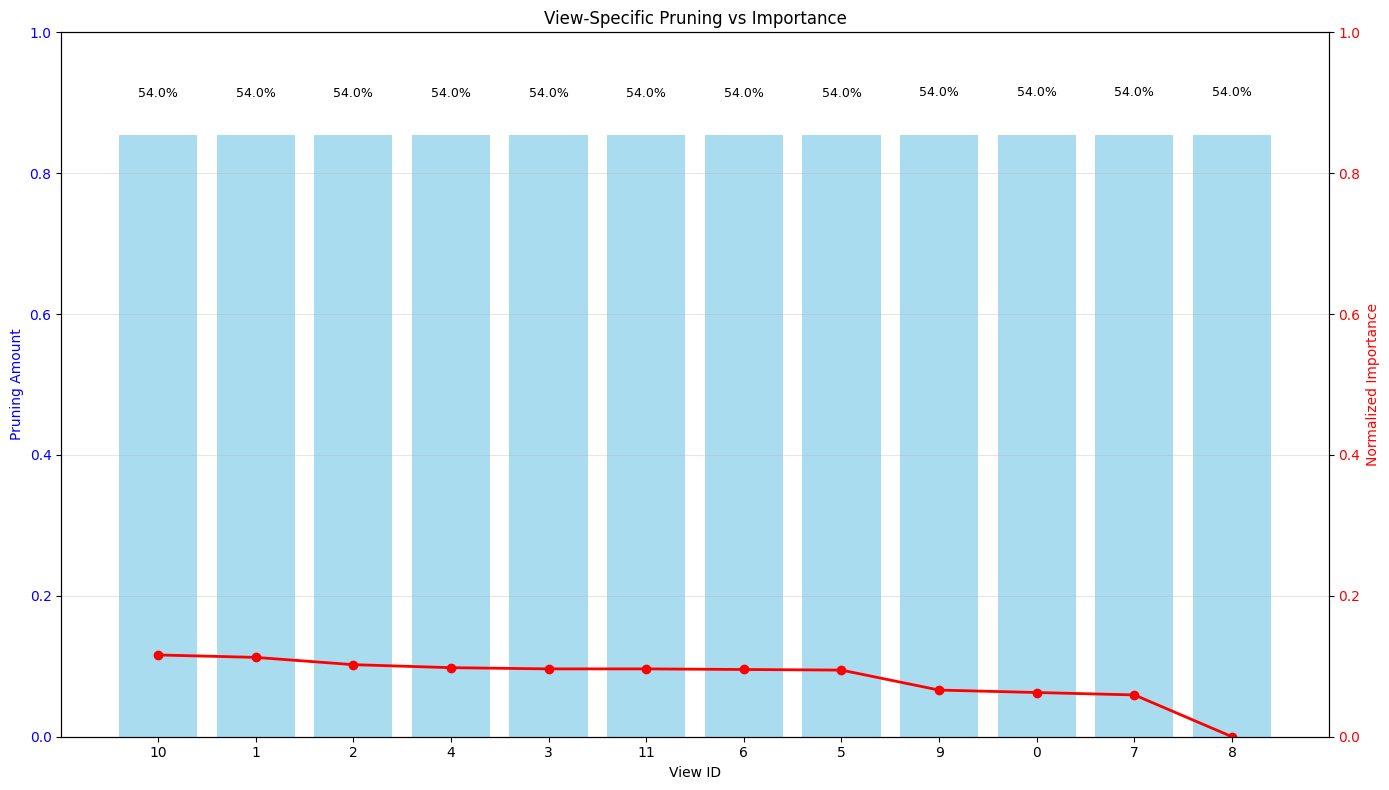

In [281]:
print("Per-view pruning amounts:", pruning_per_view)
plot_pruning_results(pruning_per_view, normalized_importance)

In [282]:
def get_details(pruning_per_view, min_accuracy, max_model_size):
    details = {}
    for view, p in pruning_per_view.items():
        details[view] = {
            'Min Accuracy Required': min_accuracy,
            'Max Model Size Required': max_model_size,
            'Pruning Amount': p,
            "Accuracy": get_accuracy(p),
            "Time": get_time(p),
            "Size": get_size(p),
            "Accuracy Reward": get_accuracy_reward(get_accuracy(p), min_accuracy),
            "Time Reward": get_comp_time_reward(get_time(p)),
            "Size Reward": get_model_size_reward(get_size(p), max_model_size),
            "More Acc Less Size Reward": more_acc_less_size(get_accuracy(p), min_accuracy, get_size(p), max_model_size),
            "Pruning Reward": p * 100,
            "Total Reward": get_reward(p, min_accuracy=min_accuracy, max_model_size=max_model_size),
        }
    return details

In [283]:
pruning_per_view

{0: 0.854675415878603,
 1: 0.8545923585939886,
 2: 0.8546080741385792,
 3: 0.8546176959028874,
 4: 0.8546149177450939,
 5: 0.8546205030771695,
 6: 0.8546191021597398,
 7: 0.8546816365913749,
 8: 0.8547926772695271,
 9: 0.8546692656043142,
 10: 0.8545873382747403,
 11: 0.854617697518521}

In [284]:
get_details(pruning_per_view, min_accuracy=min_accuracy, max_model_size=max_model_size)

{0: {'Min Accuracy Required': 80.0,
  'Max Model Size Required': 300.0,
  'Pruning Amount': 0.854675415878603,
  'Accuracy': 53.9675800187927,
  'Time': 0.316710325787388,
  'Size': 81.72006566368964,
  'Accuracy Reward': np.float64(1.5753311503970353),
  'Time Reward': np.float64(46.23140771942453),
  'Size Reward': 103.67106900323132,
  'More Acc Less Size Reward': 0,
  'Pruning Reward': 85.4675415878603,
  'Total Reward': np.float64(59.03935678313699)},
 1: {'Min Accuracy Required': 80.0,
  'Max Model Size Required': 300.0,
  'Pruning Amount': 0.8545923585939886,
  'Accuracy': 53.97744022262066,
  'Time': 0.31685590456651724,
  'Size': 81.75488327739998,
  'Accuracy Reward': np.float64(1.5790501600868732),
  'Time Reward': np.float64(46.228076512621),
  'Size Reward': 103.66950557536825,
  'More Acc Less Size Reward': 0,
  'Pruning Reward': 85.45923585939886,
  'Total Reward': np.float64(59.038134335298594)},
 2: {'Min Accuracy Required': 80.0,
  'Max Model Size Required': 300.0,
  

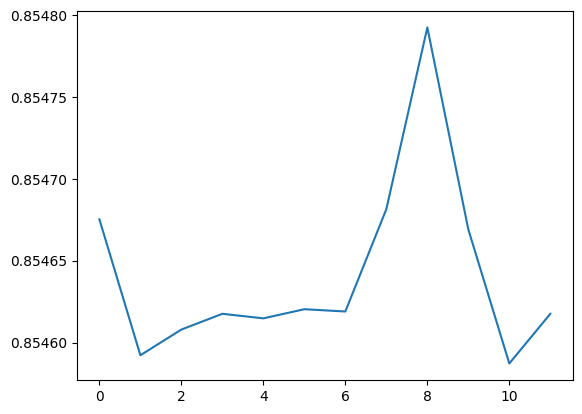

In [285]:
plt.plot(pruning_per_view.values())

In [286]:
# !jupyter nbconvert "mvcnn-results-reg-fit.ipynb" --to pdf --output "mvcnn-results-reg-fit.pdf" --no-prompt > /dev/null 2>&1

**How `alpha` and `sigma0` Influence the CMA-ES Per-View Pruning**

- **`alpha` (importance weight):**
  - Scales the penalty for pruning a view proportional to its importance.
  - A larger `alpha` forces the algorithm to preserve high-importance views (lower prune) at the expense of total reward, tightening the inverse relationship.
  - A smaller `alpha` focuses more on maximizing raw reward (accuracy, time, size) regardless of importance.

- **`sigma0` (initial step size):**
  - Determines the initial search radius of the CMA-ES optimizer for each view.
  - Larger `sigma0` explores a wider range of pruning values early but may converge more slowly or overshoot.
  - Smaller `sigma0` performs a finer, local search near the initial guess (inverse proportional starting point), which can speed up convergence but may miss better global solutions.

_Tuning these two parameters balances exploration vs. exploitation and enforces how strongly importance drives pruning decisions._

**How Combined Accuracy Is Checked**

- The per-view optimization currently uses `get_reward(p, min_accuracy)` which checks an individual view’s accuracy against the threshold.
- To enforce a **global combined accuracy** across all views, the notebook defines in `get_importance_inverse_pruning` a helper:
  ```python
  def compute_weighted_accuracy(pruning_amounts):
      # returns weighted average accuracy across all views
  ```
- After finding the best per-view pruning, you can do:
  ```python
  combined_acc = compute_weighted_accuracy(pruning_per_view)
  if combined_acc < min_accuracy:
      print(f"Combined accuracy {combined_acc:.2f}% below target {min_accuracy}%")
      # trigger re-scaling or joint optimization
  ```
- This ensures the **combined** model accuracy meets or exceeds the required threshold, rather than each view individually.